# Heart Attack Prediction Model Evaluation
1. This Notebook aims to select the best model for predicting heart attack
2. What are the important features for determining the outcome

In [1]:
# import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
from xgboost import XGBClassifier

## Load and Explore Data

In [2]:
df = pd.read_csv("heart_attack_prediction_dataset.csv")
print(df.head())

  Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Activity Days Per Week  

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [4]:
df.isnull().sum() #Look for any missing values

Patient ID                         0
Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64

In [5]:
df.duplicated().sum() #Look for any missing values

0

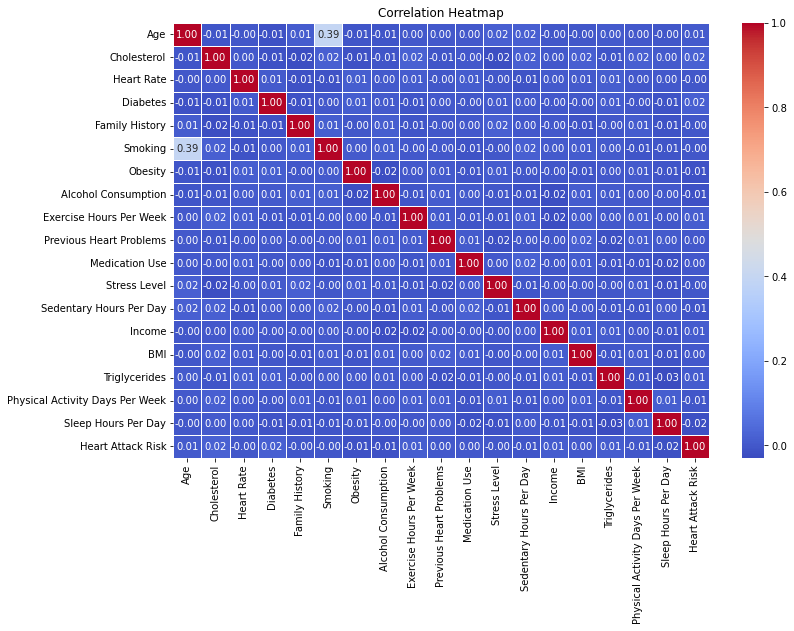

In [6]:
#Plot the correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

([<matplotlib.axis.XTick at 0x174531a8640>,
 [Text(0, 0, 'No Heart Attack'), Text(1, 0, 'Heart Attack')])

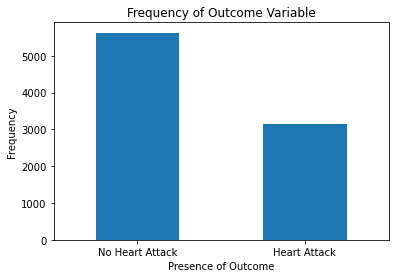

In [7]:
# Presence of Outcome
df["Heart Attack Risk"].value_counts().plot(kind='bar')
plt.title("Frequency of Outcome Variable")
plt.xlabel("Presence of Outcome")
plt.ylabel("Frequency")
plt.xticks([0,1],["No Heart Attack","Heart Attack"], rotation = 0)

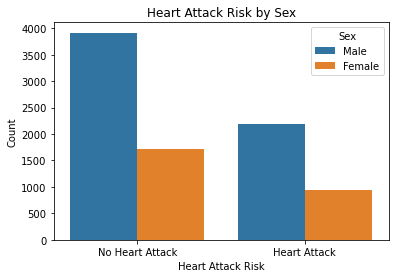

In [8]:
# Heart Attack Risk by Sex
sns.countplot(data = df, x="Heart Attack Risk" , hue = "Sex")
plt.title("Heart Attack Risk by Sex")
plt.xlabel("Heart Attack Risk")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.xticks([0,1],["No Heart Attack","Heart Attack"], rotation = 0)
plt.show()

Text(0, 0.5, 'Count')

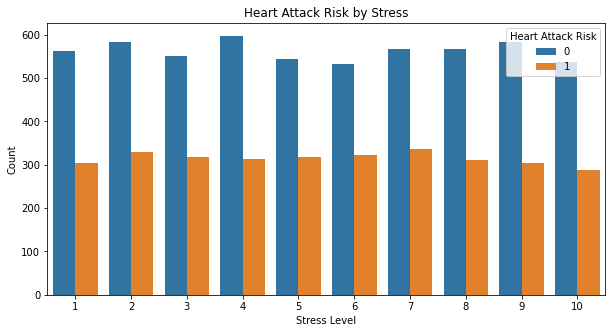

In [9]:
# Heart Attack Risk by Stress 
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Stress Level', hue='Heart Attack Risk')
plt.title("Heart Attack Risk by Stress")
plt.xlabel("Stress Level")
plt.ylabel("Count")

## Preprocess Data

In [10]:
# Drop Irrelevant Columns
df=df.drop(columns={'Patient ID','Country',
       'Continent', 'Hemisphere','Income'})

In [11]:
# Divide blood pressure into two different variables
df[['Systolic','Dystolic']]=df['Blood Pressure'].str.split('/',expand=True).astype(int)
df=df.drop(columns={'Blood Pressure'})

In [12]:
df

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Medication Use,Stress Level,Sedentary Hours Per Day,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk,Systolic,Dystolic
0,67,Male,208,72,0,0,1,0,0,4.168189,...,0,9,6.615001,31.251233,286,0,6,0,158,88
1,21,Male,389,98,1,1,1,1,1,1.813242,...,0,1,4.963459,27.194973,235,1,7,0,165,93
2,21,Female,324,72,1,0,0,0,0,2.078353,...,1,9,9.463426,28.176571,587,4,4,0,174,99
3,84,Male,383,73,1,1,1,0,1,9.828130,...,0,9,7.648981,36.464704,378,3,4,0,163,100
4,66,Male,318,93,1,1,1,1,0,5.804299,...,0,6,1.514821,21.809144,231,1,5,0,91,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,61,1,1,1,0,1,7.917342,...,1,8,10.806373,19.655895,67,7,7,0,94,76
8759,28,Female,120,73,1,0,0,1,0,16.558426,...,0,8,3.833038,23.993866,617,4,9,0,157,102
8760,47,Male,250,105,0,1,1,1,1,3.148438,...,0,5,2.375214,35.406146,527,4,4,1,161,75
8761,36,Male,178,60,1,0,1,0,0,3.789950,...,1,5,0.029104,27.294020,114,2,8,0,119,67


In [13]:
#Encode variables
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df = pd.get_dummies(df, columns=['Diet'], drop_first=True)

## Train Models

In [14]:
X = df.drop('Heart Attack Risk', axis=1)
y = df['Heart Attack Risk']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
# Scale Models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Build Dictionaries for models and metrics
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBClassifier': XGBClassifier()
}

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall':[],
    'F1':[],
    'Confusion Matrix':[],
    'Classification Report':[]
}

In [18]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy * 100)
    metrics['Precision'].append(precision * 100)
    metrics['Recall'].append(recall * 100)
    metrics['F1'].append(f1)
    metrics['Confusion Matrix'].append(cm)
    metrics['Classification Report'].append(cr)
    print(f"Model: {name}")
    print(f"Confusion Matrix: ")
    print(cm)
    print(f"Accuracy: {accuracy*100}")
    print(f"Precision: {precision*100}")
    print(f"Classificaion Report: ")
    print(cr)
    print("-" * 30)

Model: Logistic Regression
Confusion Matrix: 
[[265 295]
 [165 152]]
Accuracy: 47.5484606613455
Precision: 34.00447427293065
Classificaion Report: 
              precision    recall  f1-score   support

           0       0.62      0.47      0.54       560
           1       0.34      0.48      0.40       317

    accuracy                           0.48       877
   macro avg       0.48      0.48      0.47       877
weighted avg       0.52      0.48      0.49       877

------------------------------
Model: Decision Tree
Confusion Matrix: 
[[370 190]
 [209 108]]
Accuracy: 54.50399087799316
Precision: 36.241610738255034
Classificaion Report: 
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       560
           1       0.36      0.34      0.35       317

    accuracy                           0.55       877
   macro avg       0.50      0.50      0.50       877
weighted avg       0.54      0.55      0.54       877

-----------------------

## Evaluate Models

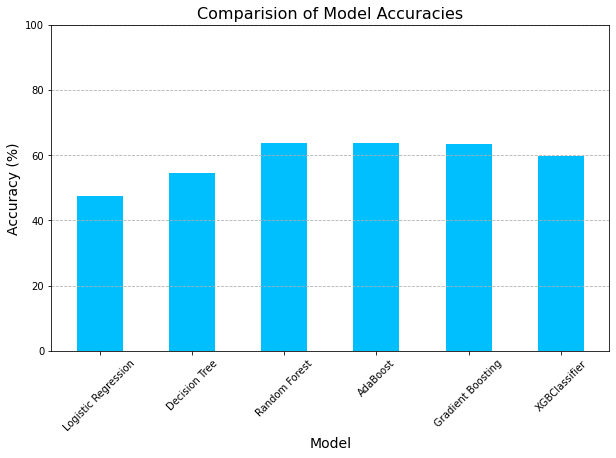

In [19]:
# PLot a bargraph of model accuracies
metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Model'], metrics_df['Accuracy'], color='deepskyblue', width=0.5)
plt.title('Comparision of Model Accuracies', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.ylim(0, 100) 
plt.show()

## Feature Importance for RFC

In [20]:
#Determining important features
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_ #Obtains the important features that determine the weights of the outcome

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [21]:
feature_importance_df

,Feature,Importance
9,Exercise Hours Per Week,0.089817
14,BMI,0.089152
13,Sedentary Hours Per Day,0.088155
15,Triglycerides,0.087410
2,Cholesterol,0.083683
18,Systolic,0.080263
0,Age,0.077674
3,Heart Rate,0.076967
19,Dystolic,0.073897
12,Stress Level,0.047555


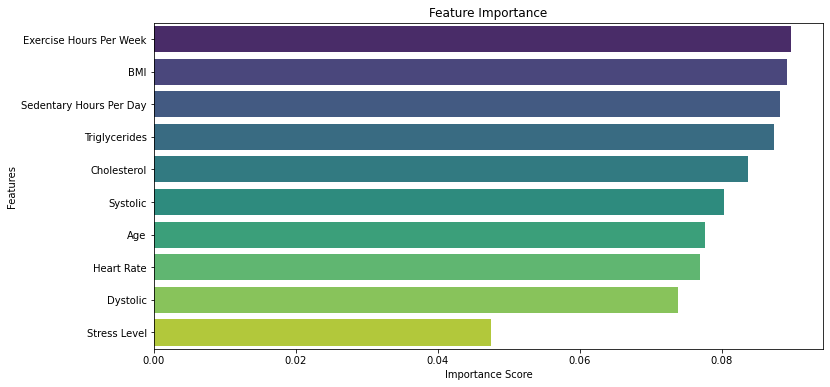

In [22]:
#Plotting Important Features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:10], palette="viridis") 
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()